# Algorithm

The objective function of soft-margin SVM is
$$ \max_\alpha W(\alpha) = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N y_i y_j k(x_i, x_j) \alpha_i \alpha_j $$
with the constraints
$$ 0 \leq \alpha_i \leq C, \text{ for any }i $$
and
$$ \sum_{i=1}^N y_i \alpha_i = 0 $$
The KKT conditions are
$$ \alpha_i = 0 \Rightarrow y_i f(x_i) \geq 1 $$
$$ 0 \leq \alpha_i \leq C \Rightarrow y_i f(x_i) = 1 $$
$$ \alpha_i = C \Rightarrow y_i f(x_i) \leq 1 $$

The sequential minimal optimization (SMO) operates with the KTT conditions of the Lagrangian multipliers directly. It solves two of these multipliers at a time, which can be done analytically. The SMO algorithm consists of three components: solving the optimization problem for two multipliers, criterion to choose which multipliers to optimize, and method to compute b.


## Two multipliers optimization
Two steps to optimize the two multipliers under consideration:
1. computes the constraints
2. solves for the maximum
Denote the two multipliers by $\alpha_1$ and $\alpha_2 $. For the constraint $\sum_{i=1}^N y_i \alpha_i = 0 $, denote the sum $\sum_{i=3}^N y_i \alpha_i = - \gamma $, we have $\gamma = y_1 \alpha_1 + y_2 \alpha_2 $. Thus $(\alpha_1, \alpha_2) $ must lie on the diagonal line $\gamma = y_1 \alpha_1 + y_2 \alpha_2 $ of the box $ 0 \leq \alpha_i \leq C $.

If $y_1$ is different from $y_2$, the bounds for $\alpha_2$ are
$$ L = \max (0, \alpha_2^{old} - \alpha_1^{old}), \quad H = \min (C, C + \alpha_2^{old} - \alpha_1^{old}) $$
In the other case where $y_1 = y_2$, the bounds are
$$ L = \max (0, \alpha_2^{old} + \alpha_1^{old} - C), \quad H = \min (C, \alpha_2^{old} + \alpha_1^{old}) $$

The derivative of the objective function along the diagonal line is
$$ \eta = 2k(x_1, x_2) - k(x_1, x_1) - k(x_2, x_2) $$
The unconstrained maximum along this direction is obtained at
$$ \alpha_2^{new} = \alpha_2^{old} - \frac{y_2(E_1 - E_2)}{\eta} $$
where $E_i = f^{old}(x_i) - y_i $. By the box constraint, the real maximum should be at
$$\alpha_2^{new, clipped} = \left\{ \begin{matrix}H, & \alpha_2^{new} \geq H\\ \alpha_2^{new}, & L < \alpha_2^{new} < H \\ L, & \alpha_2^{new} < L \end{matrix} \right. $$
Denote $s = y_1y_2$, we have
$$ \alpha_1^{new} = \alpha_1^{old} + s(\alpha_2^{old} - \alpha_2^{new, clipped}) $$

## Choose the two multipliers
The outer loop iterates over all multipliers for $\alpha_1$. If any $\alpha_i$ violates the KTT conditions, the algorithm then iterates over all other multipliers for $\alpha_2$. After one loop, the algorithm only checks $\alpha_i$'s with values 0 or C. The termination condition is that all $\alpha$'s obey the KKT conditions within $\epsilon$.

## Calculate b and threshold
After each step, updates $b$. If $\alpha_1$ is not at the bounds, then
$$ b_1 = E_1 + y_1(\alpha_1^{new} - \alpha_1^{old})k(x_1, x_1) + y_2(\alpha_2^{new, clipped} - \alpha_2^{old})k(x_1, x_2) + b^{old} $$
If $\alpha_2^{new}$ is not at bounds, then
$$ b_2 = E_2 + y_1(\alpha_1^{new} - \alpha_1^{old})k(x_1, x_2) + y_2(\alpha_2^{new, clipped} - \alpha_2^{old})k(x_2, x_2) + b^{old} $$
They are equal if both $\alpha_1$ and $\alpha_2$ are not at bounds.

# Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class linSVM(object):
    
    def __init__(self, C = 1.0, tol = 1e-3):
        self.C = C
        self.tol = tol
    
    def calError(self, i, X, y):
        yi = y[i]
        Xi = X[i, :]
        tempW = np.dot(X.T, self.alpha * y)
        predYi = np.dot(tempW.T, X[i,:][:, np.newaxis]) + self.b
        error = predYi - yi
        return error
    
    def calL(self, alphai, alphaj, yi, yj):
        if not yi == yj:
            L = max(0, alphaj - alphai)
        else:
            L = max(0, alphai + alphaj - self.C)
        return L
    
    def calH(self, alphai, alphaj, yi, yj):
        if not yi == yj:
            H = min(self.C, self.C + alphaj - alphai)
        else:
            H = min(self.C, alphai + alphaj)
        return H
    
    def calKernel(self, x, y):
        return np.dot(x.T, y)
        
    def fit(self, X, y, maxPasses = 100, maxIter = 10000):
        self.alpha = np.zeros((X.shape[0], 1))
        self.b = 0
        
        passes = 0
        
        N = X.shape[0]
        
        iterations = 0
        while passes < maxPasses and iterations < maxIter:
            numChangeAlpha = 0
            for i in range(X.shape[0]):
                # print "I is", i
                Ei = self.calError(i, X, y)
                yi = y[i]
                Xi = X[i,:][:, np.newaxis]
                if (self.alpha[i] < self.C and y[i]*Ei < -self.tol) or (y[i] * Ei > self.tol and self.alpha[i] > 0):
                    iterations += 1
                    # print "Alpha is", self.alpha[i]
                    # print "Error is", y[i]*Ei
                    j = np.random.randint(0, N - 1)
                    while j == i:
                        j = np.random.randint(0, N - 1)
                    Ej = self.calError(j, X, y)
                    yj = y[j]
                    Xj = X[j,:][:, np.newaxis]
                    alphai = self.alpha[i]
                    alphaj = self.alpha[j]
                    # print "Before updating, alpha j is", alphaj
                    L = self.calL(alphai, alphaj, yi, yj)
                    H = self.calH(alphai, alphaj, yi, yj)
                    
                    if L == H:
                        continue
                    
                    # print "J is", j
                    # print "L is", L
                    # print "H is", H
                    kii = self.calKernel(Xi, Xi)
                    kjj = self.calKernel(Xj, Xj)
                    kij = self.calKernel(Xi, Xj)
                    
                    eta = 2*kij - kii - kjj
                    
                    if eta >= 0:
                        continue
                    
                    alphaj = alphaj - yj*(Ei - Ej)/eta
                    
                    # print "Raw alpha j is", alphaj
                    
                    if alphaj > H:
                        alphaj = H
                    elif alphaj < L:
                        alphaj = L
                        
                    # print "Boxed alpha j is", alphaj
                    
                    alphai = alphai + yi*yi*(self.alpha[j] - alphai)
                    # print "alpha i is", alphai
                    
                    b1 = self.b - Ei - yi*(alphai - self.alpha[i])*kii - yj*(alphaj - self.alpha[j])*kij
                    b2 = self.b - Ej - yi*(alphai - self.alpha[i])*kij - yj*(alphaj - self.alpha[j])*kjj
                    if alphai > 0 and alphai < self.C:
                        self.b = b1
                    elif alphaj > 0 and alphaj < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2)*0.5
                    
                    self.alpha[i] = alphai
                    self.alpha[j] = alphaj
                    
                    # print "After assignment, alpha j is", self.alpha[j]
                    
                    # print "alpha_i is", alphai
                    
                    numChangeAlpha += 1
                    
               # End of if
            
            # End of for
            
            if numChangeAlpha == 0:
                passes += 1
                print "Passes number", passes
            else:
                print "Iteration with alpha changed"
                passes = 0
        
        # End of while
        # Update w
        self.w = np.dot(X.T, self.alpha * y)
    
    def predict(self, X):
        # w = np.dot(X.T, self.alpha)
        return np.sign(np.dot(X, self.w) + self.b)

# Test

In [3]:
sigma = 0.4
np.random.seed(123)
# First class: center (-1, -1)
x1x = np.random.normal(-1, sigma, 5000)
x1y = np.random.normal(-1, sigma, 5000)
X1 = np.vstack((x1x, x1y)).T
y1 = np.array([1]*5000)

# Second class: center (1, 1)
x2x = np.random.normal(1, sigma, 15000)
x2y = np.random.normal(1, sigma, 15000)
X2 = np.vstack((x2x, x2y)).T
y2 = np.array([-1]*15000)

X = np.vstack((X1, X2))
y = np.concatenate((y1, y2))[:, np.newaxis]

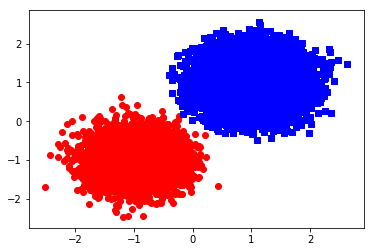

In [4]:
plt.scatter(x1x, x1y, color = 'r', marker = 'o')
plt.scatter(x2x, x2y, color = 'b', marker = 's')
plt.show()

In [5]:
svm1 = linSVM(C = 10.0, tol = 0.1)
svm1.fit(X, y, maxPasses = 200, maxIter = 1000)

Iteration with alpha changed
Iteration with alpha changed
Iteration with alpha changed
Iteration with alpha changed
Iteration with alpha changed
Iteration with alpha changed
Iteration with alpha changed
Iteration with alpha changed
Iteration with alpha changed


In [6]:
np.sum(svm1.alpha)

1.9738867178630766

In [7]:
svm1.w

array([[-1.09887463],
       [-1.49573837]])

In [8]:
svm1.b

array([[-0.08982277]])

In [9]:
Xtest = np.zeros((100, 2))
ytest = np.zeros((100, 1))
alphatest = np.zeros((100, 1))

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution = 0.02):
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha = 0.4, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                   alpha = 0.8, c = cmap(idx),
                   marker = markers[idx], label = cl)

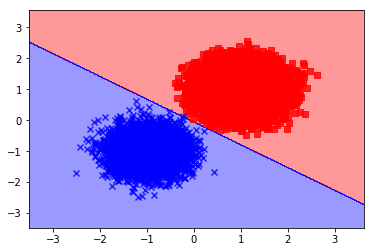

In [11]:
plot_decision_regions(X, y.reshape((y.shape[0])), svm1)